# <strong> Example battery design: Automating BatPaC V5</strong>
   

The following notebook provides an example of the battery design module. The module uses BatPaC version 5 to solve the battery design based on user specific parameters and returns the material content of specific battery design. The notebook contains three examples:

* Example 1: Single battery design
* Example 2: Including vehicle parameters
* Example 3: Several battery designs



<img src='../docs/batpac_python.png' width=800/>

In [1]:
#Import required packages

import pandas as pd
import sys
import matplotlib.pyplot as plt

#Import the battery design module from a local path
sys.path.insert(1, r'C:\Users\Joris\OneDrive - Newcastle University\Python\Projects\Batt_Sust_Model\batt_sust_model')
from battery_design import battery_design as bd

#Local Path to BatPaC version 5. 
# Make sure iterative calculations are enabled (100 iterations is sufficient, see BatPaC manual 3rd edition page 12):
path_batpac = r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\battery_sustainability_model\Case study\BatPaC 5.0 10Feb2022.xlsm"

## Example 1 - Solving a single battery pack design
The geometric design of the Volkswagen ID.3 77 kWh version as reported by
[PushEVS.com](https://pushevs.com/2020/05/13/volkswagen-meb-details/) is used as an example (NMC622 is used instead of NMC712, as the latter is not in the public version of BatPaC V5l). All other parameters are BatPaC default parameters.

* usable battery energy: 94%
* Total pack energy: 82 kWh
* Electrode pair: NMC622-G
* Silicon additive anode: 0%
* Cells per module: 24
* Modules per pack: 12
* Modules in parallel: 2 
* Cooling: liquid
* Maximum charging time: 33 minutes (ev-database.org)
* Maximum charge power: 135 kW (ev-database.org)
<br>


In [15]:
#Establish battery system class of specific design:
battery = bd.Battery_system ( vehicle_type='EV', 
                             electrode_pair='NMC622-G (Energy)', 
                             cells_per_module=24, 
                             modules_per_row=6,
                             rows_of_modules=2, 
                             cells_in_parallel=1,
                             silicon_anode= 0.00, 
                             pack_energy=82, 
                             calculate_fast_charge = 'Yes',
                             max_charging_time = 33,  
                             max_charge_power = 135, 
                             available_energy=94)
#Establish parameter dictionary
parameter_dict = battery.parameter_dictionary()

# #Solve battery design in BatPaC returning nested dictionary with material contents and parameter values
# #Make sure BatPaC is not open or running in the background. 
# #BatPaC can run in the foreground if visible=True
result_dict = bd.solve_batpac_battery_system (batpac_path = path_batpac, parameter_dict=parameter_dict, visible=True)

In [17]:
from tabulate import tabulate

headers = [' ', 'BatPaC output', 'VW ID3.']
data = [['Usable capacity (kWh)', result_dict['general_battery_parameters']['pack_usable_energy_kWh'], 77],
        ['Batter weight (kg)', round(result_dict['material_content_pack']['battery pack'],1),493],
        ['Pack energy density Wh/kg', round(82/result_dict['material_content_pack']['battery pack'],4)*1000, 166.3],
        ['Cell weight (kg)', round(result_dict['material_content_pack']['cell']/result_dict['general_battery_parameters']['cells_per_pack'],3),1.073],
        ['Cell capacity (Ah)',round(result_dict['general_battery_parameters']['cell_capacity_ah'], 2),78],
        ['Total cells',result_dict['general_battery_parameters']['cells_per_pack'],288],
        ['Cell energy density (Wh/kg)', result_dict['general_battery_parameters']['specific_energy_cell_Wh/kg'],265]
       ]

print ('Results modelled pack versus VW3 ID3. Data based on PushEV and EPA "Application for Emissions Certification" for ID.4 (same pack):')
print(tabulate(data, headers=headers, numalign="right"))


Results modelled pack versus VW3 ID3. Data based on PushEV and EPA "Application for Emissions Certification" for ID.4 (same pack):
                               BatPaC output    VW ID3.
---------------------------  ---------------  ---------
Usable capacity (kWh)                  77.08         77
Batter weight (kg)                     519.7        493
Pack energy Wh/kg                      157.8      166.3
Cell weight (kg)                       0.917      1.073
Cell capacity (Ah)                     77.62         78
Total cells                              288        288
Cell energy density (Wh/kg)          310.424        265


### Export to Excel
Results can be exported to Excel, resulting in two files: 
* 3_MC_battery_pack_materials: the material content of the battery design
* 3_PAR_battery_design parameters:  includes the design parameters and several technical parameters


In [19]:
bd.export_to_excel(result_dict, 'result_1')

## Example 2 - Including vehicle parameters


An additional vehicle model is included to calculate the required battery energy for specific vehicle parameters and a desired range. The model and interaction with BatPaC is based on a the study by [Yelin et al., 2017](https://www.sciencedirect.com/science/article/abs/pii/S0378775317300368) and [Kim and Wallington, 2016](https://pubs.acs.org/doi/10.1021/acs.est.6b02059). <br>Several input parameters that **need** to be defined. This includes the desired vehicle range in miles and the rolling resistance coefficient, rotation resistance coefficient and aerodynamic resistance coefficient, also referred to as the A, B, and C target coefficients, respectively. The target coefficients are based on the EPA vehicle testing data used to determine the fuel economy of new vehicles. Annual data can be found [here](https://www.epa.gov/compliance-and-fuel-economy-data/data-cars-used-testing-fuel-economy). <br>

In the following example, the .....


<img src='../docs/batpac_vehicle_model.png' width=600/>


In [15]:
#Establish battery system class of specific design:
battery = bd.Battery_system (    
                             vehicle_type='EV', 
                             electrode_pair='NMC622-G (Energy)', 
                             cells_per_module=24, 
                             modules_per_row=6,
                             rows_of_modules=2, 
                             cells_in_parallel=1,
                             silicon_anode= 0.00, 
                             calculate_fast_charge = 'Yes',
                             max_charging_time = 34,  #EV-database https://ev-database.org/car/1273/Volkswagen-ID4-1st
                             max_charge_power = 126,  #EV-database https://ev-database.org/car/1273/Volkswagen-ID4-1st
                             available_energy=94,
                             A_coefficient=135.9999272, #based on EPA data
                             B_coefficient= 3.732390689,#based on EPA data
                             C_coefficient=0.406771986,#based on EPA data
                             vehicle_range=410*0.6214, #EV-database using the 'EVDB Real Range' (converted to miles) https://ev-database.org/car/1273/Volkswagen-ID4-1st
                             motor_power = 150 #Based on adac.de VW ID.4 Pro Performance https://www.adac.de/rund-ums-fahrzeug/autokatalog/marken-modelle/vw/id4/1generation/318521/#technische-daten                 
                             )
#Establish parameter dictionary
parameter_dict = battery.parameter_dictionary()

# #Solve battery design in BatPaC returning nested dictionary with material contents and parameter values
# #Make sure BatPaC is not open or running in the background. 
# #BatPaC can run in the foreground if visible=True
result_dict = bd.solve_batpac_battery_system (batpac_path = path_batpac, parameter_dict=parameter_dict, visible=True)

In [30]:
from tabulate import tabulate

headers = [' ', 'Modelled', 'VW ID4. Pro']
data = [['Usable capacity (kWh)', round(result_dict['general_battery_parameters']['pack_usable_energy_kWh'],0), 77],
        ['Vehicle weight (kg)', round(result_dict['general_battery_parameters']['vehicle_weight'],0),2124 ],
        ['Battery weight (kg)', round(result_dict['material_content_pack']['battery pack'],0),493],
        ['Pack energy density Wh/kg', round(82/result_dict['material_content_pack']['battery pack'],4)*1000, 166.3],
        ['Cell weight (kg)', round(result_dict['material_content_pack']['cell']/result_dict['general_battery_parameters']['cells_per_pack'],3),1.073],
        ['Glider weight (kg)', round(result_dict['general_battery_parameters']['glider_weight'],1),  0],
        ['Motor weight (kg)', round(result_dict['general_battery_parameters']['motor_controller_weight'],0), 0 ],
        ['Transmission weight (kg)', round(result_dict['general_battery_parameters']['transmission_weight'],0), 0 ],

       ]

print ('Results modelled vehicle versus VW ID4 Pro (reported weight based on adac.de):')
print(tabulate(data, headers=headers, numalign="right"))


Results modelled vehicle versus VW ID4 Pro (reported weight based on adac.de):
                             Modelled    VW ID4. Pro
-------------------------  ----------  -------------
Usable capacity (kWh)              84             77
Vehicle weight (kg)              2216           2124
Battery weight (kg)               545            493
Pack energy density Wh/kg       150.5          166.3
Cell weight (kg)                0.981          1.073
Glider weight (kg)               1382              0
Motor weight (kg)                 175              0
Transmission weight (kg)          114              0


## Example 3 - Solving multiple battery designs
In the following example, the battery design module is used to iterate through several design parameters and solve the battery system for several batteries. <br>
Using the function 'solve_batpac_battery_system_multiple', BatPaC is kept open in the background and the model solved for each design parameter (takes about 3 <br>
second to solve BatPaC in Excel with 100 iterations per calculation enabled). <br>

In this example, we will iterature through different cathode chemistries and current collector thickness to identify if the above results can be improved to better match the VW ID.3:

* cathode chemistry: NMC622-G and NMC811-G
* anode current collector thickness: 6 and 8
* cathode current collector thickness: 10 and 12
 <br>



In [ ]:
import itertools as itertools

cathode_chemistry         = ['NMC622-G (Energy)', 'NMC811-G (Energy)']
anode_current_collector   = [6, 8]
cathode_current_collector = [10,12]

dict_design = {}

param_all = list(itertools.product(cathode_chemistry,anode_current_collector,cathode_current_collector))
for param in param_all:
    battery = bd.Battery_system (vehicle_type='EV', electrode_pair=param[0], cells_per_module=24, modules_per_row=6,rows_of_modules=2, 
                                 cells_in_parallel=1,silicon_anode= 0.00, pack_energy=82, available_energy=94, 
                                 negative_foil_thickness=param[1], positive_foil_thickness=param[2])
    parameter_dict = battery.parameter_dictionary()

    #Save each BatPaC output in design dictionary:
    dict_design[param] = parameter_dict
    

Solve BatPaC design model for all battery design options:
Make sure BatPaC is closed

In [ ]:

result_dict_all = bd.solve_batpac_battery_system_multiple (batpac_path = path_batpac, parameter_dict_all=dict_design, visible=True)

  0%|          | 0/8 [00:00<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'Application'

In [ ]:
data = range(0,5)

In [ ]:

s  = [result_dict_all[x]['general_battery_parameters']['specific_energy_cell_Wh/kg'] for x in result_dict_all.keys()]
d  = [result_dict_all[x]['general_battery_parameters']['energy_density_cell_Wh/L'] for x in result_dict_all.keys()]
    


In [ ]:
s

[328.6117544498728,
 327.3815524393312,
 324.3567105956372,
 323.1542204951903,
 351.909430483573,
 350.64695466113983,
 347.52996729758473,
 346.30102107304566]

In [ ]:
d

[653.315176490761,
 650.7420686292885,
 650.701170647415,
 648.0372177306646,
 685.1025541411351,
 682.4503814488081,
 682.408860825856,
 679.8937159567159]

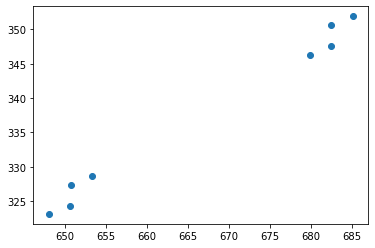

In [ ]:
plt.scatter(d,s)

In [ ]:
headers = ['Example 1',*result_dict_all.keys(), 'VW ID3.']

import matplotlib.pyplot as plt

capacity = []
wt_cell = []
cap_cell= []
total_cell = []
density = []
for x in result_dict_all.keys():
    capacity.append(result_dict_all[x]['general_battery_parameters']['pack_usable_energy_kWh'])
    wt_cell.append(round(result_dict_all[x]['material_content_pack']['cell']/result_dict_all[x]['general_battery_parameters']['cells_per_pack'],3))
    cap_cell.append(round(result_dict_all[x]['general_battery_parameters']['cell_capacity_ah'], 2))
    total_cell.append(result_dict_all[x]['general_battery_parameters']['cells_per_pack'])
    density.append(result_dict_all[x]['general_battery_parameters']['specific_energy_cell_Wh/kg'])

data[0][1:1]=capacity
data[1][1:1]=wt_cell
data[2][1:1]=cap_cell
data[3][1:1]=total_cell
data[4][1:1]=density


headers = ['Baseline',*[str(k) for k in result_dict_all.keys()], 'VW ID3.']

print ('Results modelled pack versus VW3 ID3. pack as reported by PushEVS:\n')
print(tabulate(data, headers=headers, numalign="right"))

TypeError: 'int' object does not support item assignment

In [ ]:
from pathlib import Path
import numpy as np

def plot_bar_chart (result_dict, path_comp_type_linkage=None, save=True, name=None):
    """ Plots a donut diagram of the battery bills of material
    Args:
        result_dict (dict): dictionary of battery design module output by name
        comp_type_linkage (str): Path to Excel sheet with battery components by type. Default location is 1_battery_design_module
    """   
    df_types = pd.read_excel(path_comp_type_linkage, index_col='component')

    result = result_dict['material_content_pack']

    df_types[name] = df_types.index.map(result).fillna(0)
    df_types = df_types[(df_types != 0).all(1)]
    df_types = df_types.groupby(['component_type', 'part_off']).sum()
    df_types.sort_values(by='part_off', ascending=True, inplace=True)
    df_types = df_types.reset_index(level=[1])
    df_types.drop('part_off', axis=1, inplace=True)
    labels = list(df_types.index)
    values = list(df_types['result'])

    return df_types
